In [1]:
import glob
import pandas as pd

module_mapping_path = "D:/Praca Magisterska/tell1_parameters_analysis-prometeusz/data/others/module_mapping.csv"

module_mapping = pd.read_csv(module_mapping_path, sep=' ', usecols=[4,5])
module_mapping = module_mapping.dropna()
module_mapping[["sensor_number"]] = module_mapping[["sensor_number"]].astype('int64')
mapping_dict = module_mapping.set_index('sensor_number').T.to_dict('list')


KeyboardInterrupt: 

In [2]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import datetime
import os
import time


def board_to_type(board):
    board_number = int(board.replace("VeloTELL1Board", ""))
    return mapping_dict[board_number][0]


files_raw = glob.glob("D:/Praca Magisterska/nowe/pedestals_subtracted/2018/wtte/*.csv")
files_calib = glob.glob("D:/Praca Magisterska/nowe/Tell1CalibCsv/wtte/*.csv")

# Read callibrations dates:
calib_timestamps = []
for file in files_calib:
    file_name = os.path.basename(file)
    file_name_timestamp = datetime.datetime.strptime(file_name, '%Y_%m_%d-%H_%M_%S.csv')
    calib_timestamps.append(file_name_timestamp)


stddevs = []
stddevs_r = []
stddevs_phi = []
deltatimes_from_previous = []
timestamps = []
days_to_calibration = []
cycle = []
cycle_measurement = []
cycle_counter = 1
measurement_counter = 1
counter = 0
for file in files_raw:
    # Read all data:
    data = pd.read_csv(file, sep=' ', header=None, usecols=range(2, 2053))
    
    # Extract measurement timestamp
    timestamp = datetime.datetime.strptime(data.iloc[0][4], '%Y-%m-%dT%H:%M:%S')
#     print(data.iloc[0][3])
    timestamps.append(timestamp)
    
    del data[3]
    del data[4]
    
    data[2] = data[2].apply(board_to_type)
    data_r = data[data[2]=='R']
    data_phi = data[data[2]=='phi']
    del data[2]
    del data_r[2]
    del data_phi[2]
    
    
    # Calculate stddev
    stddev = data.stack().std()
    stddevs.append(stddev)
    stddev_r = data_r.stack().std()
    stddevs_r.append(stddev_r)
    stddev_phi = data_phi.stack().std()
    stddevs_phi.append(stddev_phi)
    
    if timestamp > calib_timestamps[cycle_counter]:
        cycle_counter = cycle_counter + 1
        measurement_counter = 1
        for i in range(-10,0):
            days_to_calibration[i] = 0
        

    cycle.append(cycle_counter)
    cycle_measurement.append(measurement_counter)


    if measurement_counter == 1:
        deltatime_from_previous = 0
    else:
        deltatime_from_previous = (time.mktime(timestamp.timetuple()) - time.mktime(timestamps[counter - 1].timetuple())) / 86400

    measurement_counter = measurement_counter + 1
        
    deltatimes_from_previous.append(deltatime_from_previous)
    days_to_calib = (time.mktime(calib_timestamps[cycle_counter].timetuple()) - time.mktime(timestamp.timetuple())) / 86400
    days_to_calibration.append(days_to_calib)

    counter = counter + 1


train_x = np.array([cycle, cycle_measurement, stddevs, stddevs_r, stddevs_phi, deltatimes_from_previous]).transpose()
train_y = np.array([days_to_calibration]).transpose()

import csv

np.savetxt("D:/Praca Magisterska/nowe/stddevs/train_x.csv", train_x, delimiter=",")
np.savetxt("D:/Praca Magisterska/nowe/stddevs/train_y.csv", train_y, delimiter=",")

AttributeError: module 'pandas' has no attribute 'core'

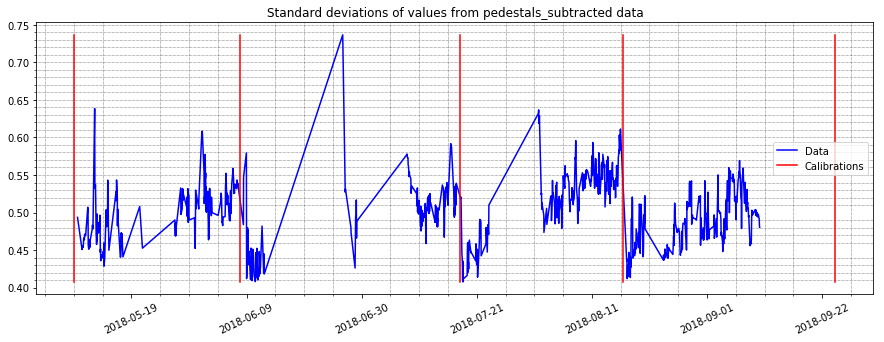

In [26]:
fig, ax = plt.subplots()
ax.set_title('Standard deviations of values from pedestals_subtracted data')
ax.plot(timestamps, stddevs, 'b', label='Data')

for calib_timestamp in calib_timestamps:
    ax.plot([calib_timestamp, calib_timestamp], [min(stddevs), max(stddevs)], 'r', label='Calibrations')

plt.xticks(rotation=25)
plt.rcParams['figure.figsize'] = [15, 5]
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.legend()
plt.show()

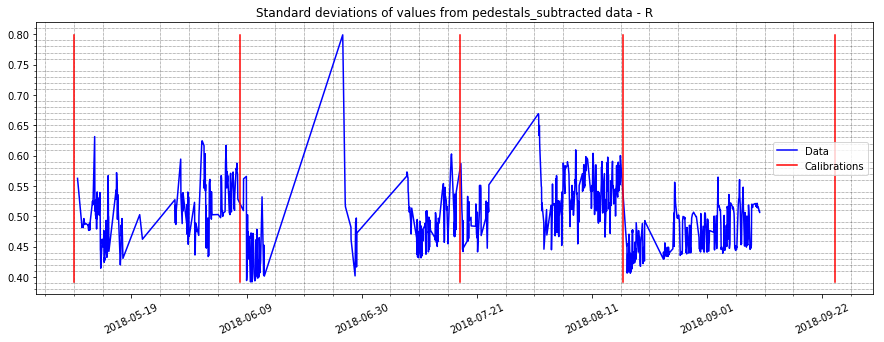

In [24]:
fig, ax = plt.subplots()
ax.set_title('Standard deviations of values from pedestals_subtracted data - R')
ax.plot(timestamps, stddevs_r, 'b', label='Data')

for calib_timestamp in calib_timestamps:
    ax.plot([calib_timestamp, calib_timestamp], [min(stddevs_r), max(stddevs_r)], 'r', label='Calibrations')

plt.xticks(rotation=25)
plt.rcParams['figure.figsize'] = [15, 5]
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.legend()
plt.show()

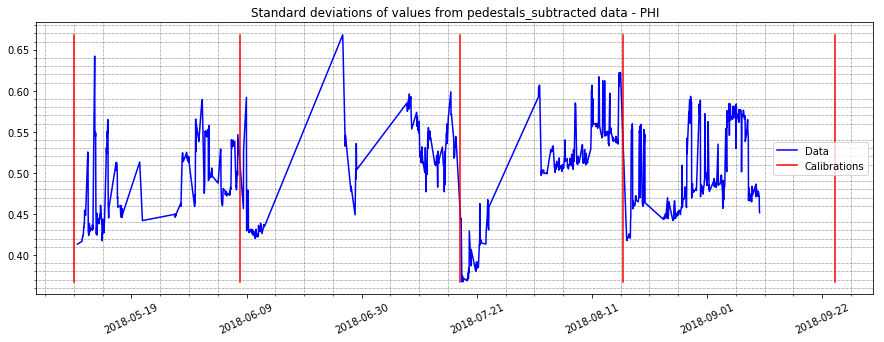

In [25]:
fig, ax = plt.subplots()
ax.set_title('Standard deviations of values from pedestals_subtracted data - PHI')
ax.plot(timestamps, stddevs_phi, 'b', label='Data')

for calib_timestamp in calib_timestamps:
    ax.plot([calib_timestamp, calib_timestamp], [min(stddevs_phi), max(stddevs_phi)], 'r', label='Calibrations')

plt.xticks(rotation=25)
plt.rcParams['figure.figsize'] = [15, 5]
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.legend()
plt.show()